In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.plot import Plot
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import generation_signal
from likelihood_calculation import minimisation_locale,minimisation_globale,print_results


### Génération du signal
Paramètre du signal initial que l'on génère :

In [2]:
seglen = 4
sample_rate = 2048
fmin = 5.
# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
            # Paramètres intrinsèques à la source
            'mass1': 38.6,
            'mass2': 29.3,
            'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
            'eccentricity': 0,
            # Paramètres extrinsèques
            'ra': 1.37, 'dec': -1.26, 'distance': 1000,
            'polarization': 2.76, 'inclination': 0,
            'tc': 3.1 , 'coa_phase': 0}

approximant='IMRPhenomD'

para_reels = np.array([cbc_params['tc'],cbc_params['mass1'], cbc_params['mass2'],cbc_params['distance'],
                       cbc_params['ra'], cbc_params['dec'],cbc_params['polarization'],
                       cbc_params['inclination'],cbc_params['spin1z'],cbc_params['spin2z']])

signal = generation_signal.Signal_GW(seglen,sample_rate,fmin,cbc_params,approximant)

Génération selon les appareils de ET :

In [3]:
signalGW_ET = signal.signal_ET()
print(signalGW_ET)

{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7ff4e6181dc0>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7ff4326f3bb0>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7ff4326f3fd0>}


Génération selon LIGO (H1,L1) :

In [6]:
signalGW_LIGO = signal.signal_LIGO()
print(signalGW_LIGO)

{'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fdc159d72b0>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fdc159d7640>}


Comparaison en fréquence des différents interféromètres :

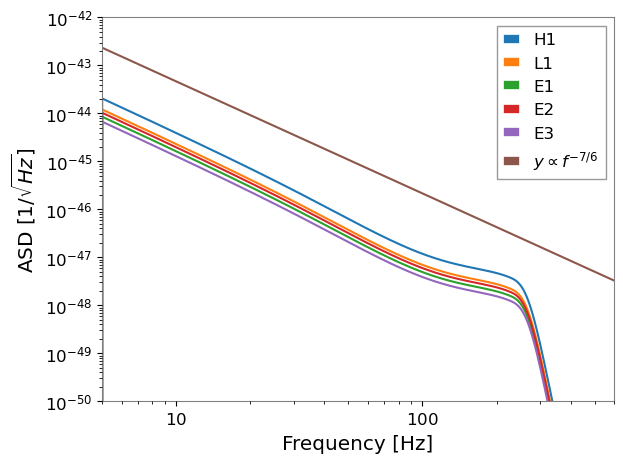

In [6]:
plt.loglog(signalGW_LIGO['H1'].get_sample_frequencies(), np.abs(signalGW_LIGO['H1'])**2,label='H1')
plt.loglog(signalGW_LIGO['L1'].get_sample_frequencies(), np.abs(signalGW_LIGO['L1'])**2, label='L1')
plt.loglog(signalGW_ET['E1'].get_sample_frequencies(), np.abs(signalGW_ET['E1'])**2,label='E1')
plt.loglog(signalGW_ET['E2'].get_sample_frequencies(), np.abs(signalGW_ET['E2'])**2,label='E2')
plt.loglog(signalGW_ET['E3'].get_sample_frequencies(), np.abs(signalGW_ET['E3'])**2,label='E3')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [1/$\sqrt{Hz}]$')
y = signalGW_LIGO['H1'].get_sample_frequencies()**(-7/3)
#plt.loglog(signal_H1L1['H1'].get_sample_frequencies(), 1e-41*y, label=r'$y\propto f^{-7/6}$')
plt.loglog(signalGW_ET['E1'].get_sample_frequencies(), 1e-41*y, label=r'$y\propto f^{-7/6}$')
plt.legend()
plt.ylim(1e-50, 1e-42)
plt.xlim(5, 600)
plt.grid()
plt.tight_layout()
plt.savefig('Telescopes_ET_LIGO_comparaison')

### (CHOIX1) Signal sans buit

In [6]:
model_normal = signal.signal_simple(signalGW_ET)

### (CHOIX2) Signal avec bruit

In [4]:
model_noise = signal.signal_noise(signalGW_ET)

In [5]:
model_noise.update(**cbc_params)
print('Log likelihood: {:.2f}'.format(model_noise.loglikelihood))
print('Log likelihood noise: {:.2f}'.format(model_noise.lognl))
print('Log likelihood ratio: {:.2f}'.format(model_noise.loglr))

Log likelihood: -11992.04
Log likelihood noise: -152756.00
Log likelihood ratio: 140763.96


In [6]:
snr_E1_sq = model_noise.det_optimal_snrsq('E1')
snr_E2_sq = model_noise.det_optimal_snrsq('E2')
snr_E3_sq = model_noise.det_optimal_snrsq('E3')

log_noise_likelihood_from_SNR = -0.5 * (snr_E1_sq + snr_E2_sq + snr_E3_sq)

print('SNR E1: {:.2f}'.format(snr_E1_sq**0.5))
print('SNR E2: {:.2f}'.format(snr_E2_sq**0.5))
print('SNR E3: {:.2f}'.format(snr_E3_sq**0.5))

print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

SNR E1: 306.29
SNR E2: 337.09
SNR E3: 272.18
Expected log likelihood noise: -140763.49


### Minimisation en utilisant un DataFrame : minimums LOCAUX

Fonction scipy.optimize.minimize.

In [ ]:
mass1_init = 30
mass2_init = 30
initial_params = [3.1, mchirp_from_mass1_mass2(mass1_init,mass2_init),
                   q_from_mass1_mass2(mass1_init,mass2_init), 1000, 1.37, -1.26,2.76,0,0,0]
result, initial_params = minimisation_locale(model_noise,initial_params,save_data=False,follow_lik=True)

In [8]:
print_results(result,para_reels,initial_params)

Paramètres initiaux :
$t_c$ : 3.1, $m_1$ : 30.0, $m_2$ : 30.0, $d_L$ : 1000, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0, s1z : 0, s2z : 0.

Paramètres d'optimisation trouvés (local) :
$t_c$ : 3.1, $m_1$ : 30.0, $m_2$ : 30.0, $d_L$ : 1000.0, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0.0, s1z : -0.0, s2z : -0.0.

Paramètres réels :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0.0, s1z : 0.0, s2z : 0.0.


Création des listes associées aux paramètres à partir du DataFrame. Premier plot de l'évolution de la minimisation $t_c$ et $m_1$.

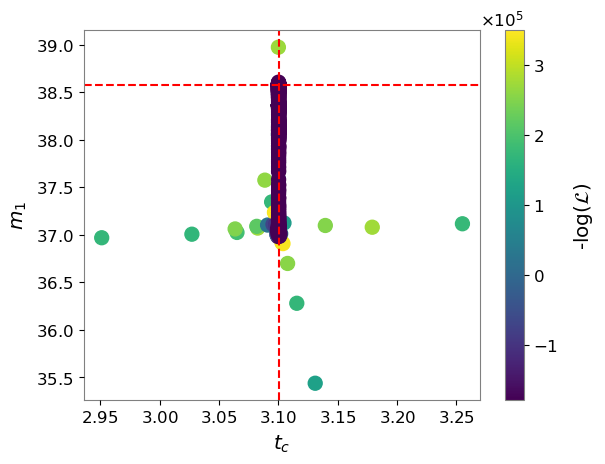

In [145]:
tc_list=params_dataFrame['tc']
mass1_list=params_dataFrame['mass1']
mass2_list=params_dataFrame['mass2']
distance_list=params_dataFrame['distance']
ra_list=params_dataFrame['ra']
dec_list=params_dataFrame['dec']
pola_list=params_dataFrame['polarization']
incl_list=params_dataFrame['inclination']
s1z_list=params_dataFrame['spin1z']
s2z_list=params_dataFrame['spin2z']
ll_ratio_test=params_dataFrame['mloglik']

plt.scatter(tc_list, mass1_list, c=ll_ratio_test, cmap='viridis', s=100)
plt.xlabel(r'$t_c$')
plt.ylabel(r'$m_1$')
plt.grid()
data_tail = params_dataFrame.loc[params_dataFrame['mloglik'].idxmin()]
plt.axhline(float(data_tail['mass1']),linestyle = 'dashed',color='r')
plt.axvline(float(data_tail['tc']),linestyle = 'dashed',color='r')
colorbar = plt.colorbar(orientation='vertical')
colorbar.set_label(r'-log($\mathcal{L}$)', labelpad=10)

Plot des graphs d'évolution de la minimisation pour toutes les combinaisons de paramètres associées à notre minimisation : minimums LOCAUX.

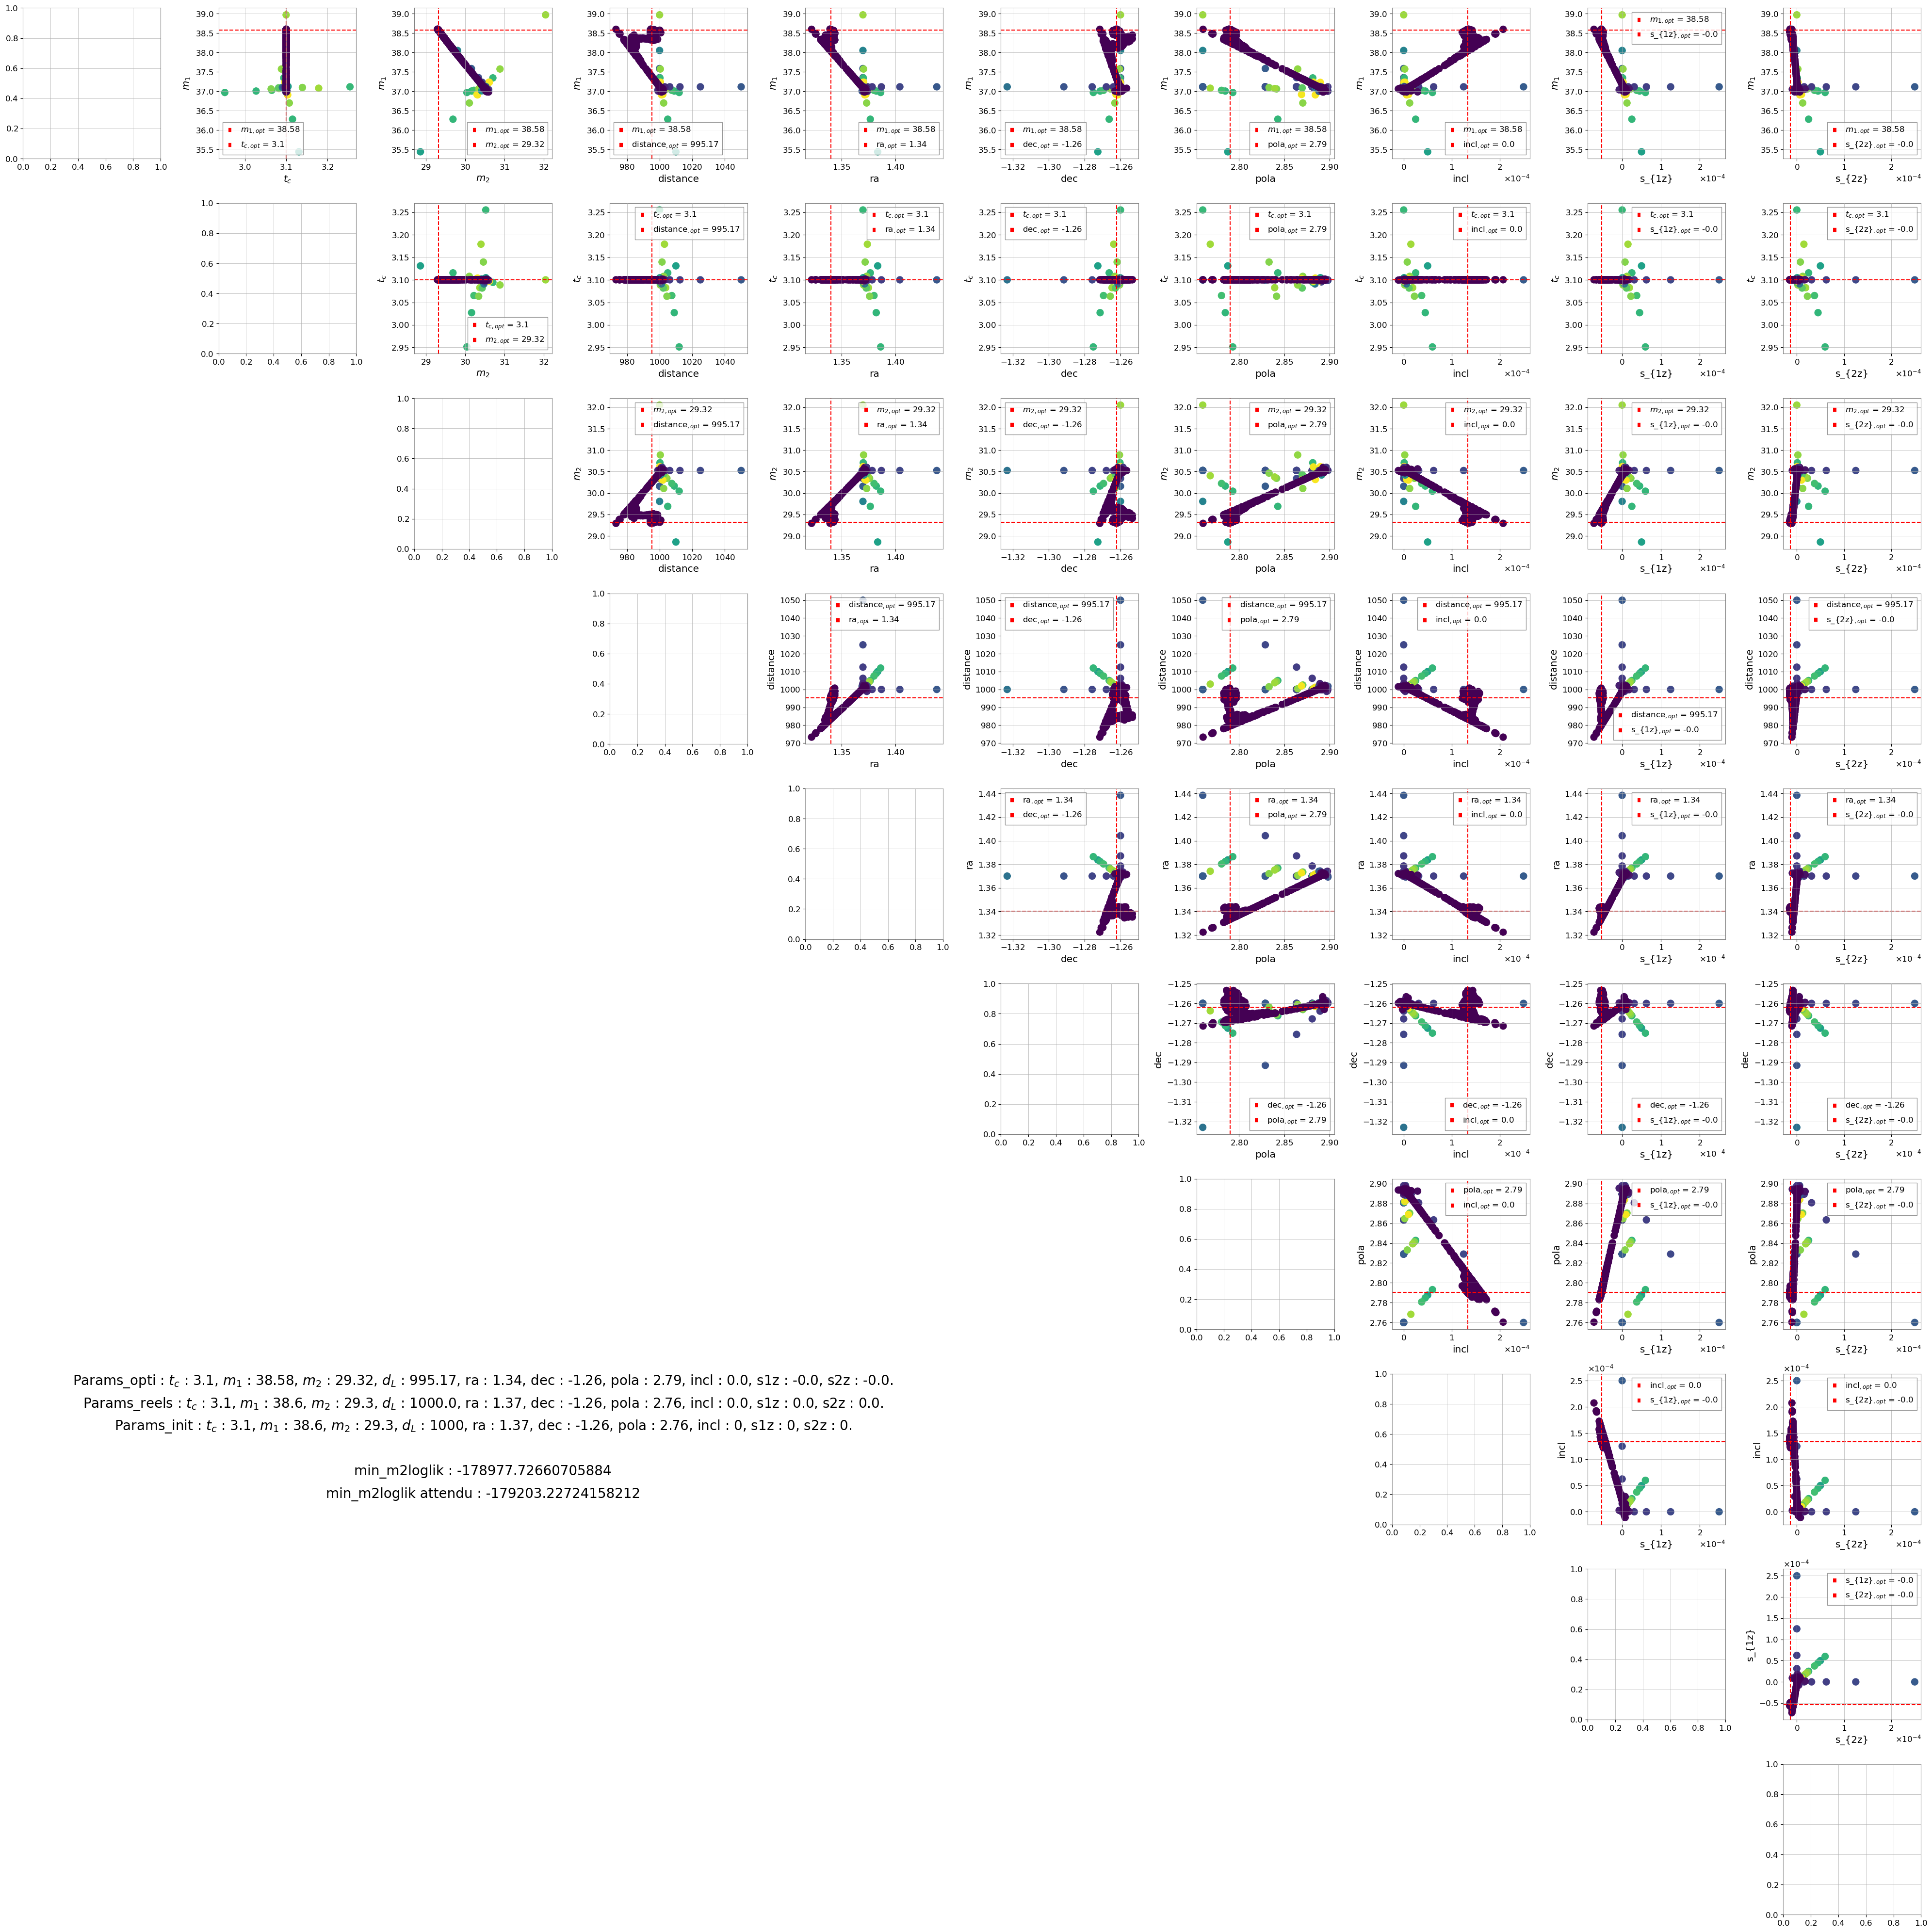

In [147]:
nb_params = len(para_reels)
fig, axs = plt.subplots(nrows=nb_params,ncols=nb_params,figsize=(40,40))


def plot_corr(x_list,y_list,label_x,label_y,data_x,data_y,ax,data_tail):
    ax.scatter(x_list, y_list, c=ll_ratio_test, cmap='viridis', s=100)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.axhline(float(data_tail[data_y]),linestyle = 'dashed',color='r', label=label_y + r'$_{,opt}$ = ' + str(round(float(data_tail[data_y]),2)))
    ax.axvline(float(data_tail[data_x]),linestyle = 'dashed',color='r', label=label_x + r'$_{,opt}$ = ' + str(round(float(data_tail[data_x]),2)))
    ax.legend()

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],   axs[0,6],       axs[0,7],      axs[0,8],   axs[0,9],   axs[1,2],    axs[1,3],     axs[1,4], axs[1,5], axs[1,6],        axs[1,7],      axs[1,8],  axs[1,9],  axs[2,3],      axs[2,4],   axs[2,5],   axs[2,6],       axs[2,7],      axs[2,8],   axs[2,9],   axs[3,4],      axs[3,5],      axs[3,6],       axs[3,7],      axs[3,8],      axs[3,9],      axs[4,5], axs[4,6],       axs[4,7],      axs[4,8],  axs[4,9],  axs[5,6],       axs[5,7],      axs[5,8],  axs[5,9],  axs[6,7],      axs[6,8],       axs[6,9],       axs[7,8],      axs[7,9],      axs[8,9]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   pola_list,      incl_list,     s1z_list,   s2z_list,   mass2_list, distance_list, ra_list,  dec_list,  pola_list,      incl_list,     s1z_list,  s2z_list,  distance_list, ra_list,    dec_list,   pola_list,      incl_list,     s1z_list,   s2z_list,   ra_list,       dec_list,      pola_list,      incl_list,     s1z_list,      s2z_list,      dec_list, pola_list,      incl_list,     s1z_list,  s2z_list,  pola_list,      incl_list,     s1z_list,  s2z_list,  incl_list,     s1z_list,       s2z_list,       s1z_list,      s2z_list,      s2z_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, mass1_list,     mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,   tc_list,        tc_list,       tc_list,   tc_list,   mass2_list,    mass2_list, mass2_list, mass2_list,     mass2_list,    mass2_list, mass2_list, distance_list, distance_list, distance_list,  distance_list, distance_list, distance_list, ra_list,  ra_list,        ra_list,       ra_list,   ra_list,   dec_list,       dec_list,      dec_list,  dec_list,  pola_list,     pola_list,      pola_list,      incl_list,     incl_list,     s1z_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}',  r'$m_2$',   r'distance',   r'ra',    r'dec',    r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}',  r'ra',         r'dec',        r'pola',        r'incl',       r's_{1z}',     r's_{2z}',     r'dec',   r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'incl',       r's_{1z}',      r's_{2z}',      r's_{1z}',     r's_{2z}',     r's_{2z}']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$m_1$',       r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$',  r'$t_c$',       r'$t_c$',      r'$t_c$',  r'$t_c$',  r'$m_2$',      r'$m_2$',   r'$m_2$',   r'$m_2$',       r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'distance',    r'distance',   r'distance',   r'distance',   r'ra',    r'ra',          r'ra',         r'ra',     r'ra',     r'dec',         r'dec',        r'dec',    r'dec',    r'pola',       r'pola',        r'pola',        r'incl',       r'incl',       r's_{1z}']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z',   'mass2',    'distance',    'ra',     'dec',     'polarization', 'inclination', 'spin1z',  'spin2z',  'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z',   'ra',          'dec',         'polarization', 'inclination', 'spin1z',      'spin2z',      'dec',    'polarization', 'inclination', 'spin1z',  'spin2z',  'polarization', 'inclination', 'spin1z',  'spin2z', 'inclination',  'spin1z',       'spin2z',       'spin1z',      'spin2z',      'spin2z']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'mass1',        'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',      'tc',           'tc',          'tc',      'tc',      'mass2',       'mass2',    'mass2',    'mass2',        'mass2',       'mass2',    'mass2',    'distance',    'distance',    'distance',     'distance',    'distance',    'distance',    'ra',     'ra',           'ra',          'ra',      'ra',      'dec',          'dec',         'dec',     'dec',    'polarization', 'polarization', 'polarization', 'inclination', 'inclination', 'spin1z']

for i in range(len(axs_list)):
    plot_corr(x_list[i],y_list[i],label_x[i],label_y[i],data_x[i],data_y[i],axs_list[i],data_tail)

fig.tight_layout()



axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[6,0],axs[7,0],axs[8,0],axs[9,0],
           axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4],
           axs[6,1],axs[6,2], axs[6,3], axs[6,4],axs[6,5],
           axs[7,1],axs[7,2], axs[7,3], axs[7,4],axs[7,5],axs[7,6],
           axs[8,1],axs[8,2], axs[8,3], axs[8,4],axs[8,5],axs[8,6],axs[8,7],
           axs[9,1],axs[9,2], axs[9,3], axs[9,4],axs[9,5],axs[9,6],axs[9,7],axs[9,8]]
for i in axs_off:
    i.axis('off')
ax=axs[7,2]
ax.text(0.5, 0.95, r'Params_opti : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(round(para_opti[0],2),
     mass1_opti, mass2_opti, round(para_opti[3],2), round(para_opti[4],2), round(para_opti[5],2),round(para_opti[6],2),round(para_opti[7],2),round(para_opti[8],2),
     round(para_opti[9],2)), horizontalalignment='center',verticalalignment='center',fontsize=20)
ax.text(0.5, 0.80, r'Params_reels : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5],para_reels[6],para_reels[7],para_reels[8],para_reels[9]), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
ax.text(0.5, 0.65, r'Params_init : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(initial_params[0],
     mass1_init, mass2_init, initial_params[3], initial_params[4], initial_params[5],initial_params[6],initial_params[7],initial_params[8],
     initial_params[9]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=20)
ax.text(0.5, 0.35, r'min_m2loglik : {}'.format(result.fun), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
ax.text(0.5, 0.20, r'min_m2loglik attendu : {}'.format(log_noise_likelihood_from_SNR), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)

plt.savefig("minimisation/Full_Minimisation_chirp_locaux_signal_noise")

### Minimisation en utilisant un DataFrame : minimums GLOBAUX

On utilise cette fois la fonction scipy.optimize.basinhopping.

In [7]:
result_glob = minimisation_globale(model_noise,method = "L-BFGS-B",tol=50,
                                   log_noise_likelihood_from_SNR=log_noise_likelihood_from_SNR,save_data=False)

Expected log likelihood noise: -140763.49
min : 806.0147598824237, it : 1
min : 598.7629394094807, it : 2
min : -1340.9836021510212, it : 3


KeyboardInterrupt: 

In [140]:
bounds=((0,10),(1,500),(0.1,20),(10,10000),(0,7.5),(-4,4),(0,7.5),(0,4),(-1,1),(-1,1))
param_min = np.array([0,     1, 0.2,    200,   0,  -4,   0,   0,   -1,   -1])
param_max = np.array([10,  500,  20, 10000, 7.5,   4, 7.5,   4,    1,    1])
borne_min_norm = np.zeros(len(param_min))
borne_max_norm = borne_min_norm
step = np.array([   1.5,    10,   1.5,     5,   3,   3,   3,   2,  0.1,    0.1])
test = np.array([0,0.1,0.2,1]) #liste initiale
bornes_inf_sup_scaled=()
for i in range(len(param_min)):
    delta = param_max[i] - param_min[i]
    points = delta/step[i] #nombre de points
    bornes_inf_sup_scaled += (0,points*0.1) #bornes à donner.
print(bornes_inf_sup_scaled)


# point=[0.1,0.2,0.3,bornes_inf_sup_scaled[1]]
# for j in range(len(point)):
#     borne_min_norm[j] = param_min[i] + point[j]*(step[i]/0.1)
#     print(param_min[i] + point[j]*(step[i]/0.1))

# test_ = np.array([bornes_inf_sup_scaled[0],bornes_inf_sup_scaled[1], bornes_inf_sup_scaled[1]+0.1,bornes_inf_sup_scaled[3]]) #liste à donner en argument de la minimisation
# print(test_)
# #print([(param_max[i]-param_min[i])*x + param_min[i] for i in range(len(param_min))])

# data_x = np.array(['tc',   'mass1',    'mass2',    'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z'])
# a=len(data_x)
# print(a)
# #del range
# for i in range(len(data_x)):
#     bornes_inf_sup_scaled=test/scale[i] #bornes à donner.
#     test_ = np.array([bornes_inf_sup_scaled[0],bornes_inf_sup_scaled[1], bornes_inf_sup_scaled[1]+0.1,bornes_inf_sup_scaled[3]]) #liste à donner en argument de la minimisation
#     print(data_x[i],test_,(((param_max[i]-param_min[i])/step)*0.1 + param_min[i]))


(0, 0.6666666666666667, 0, 4.99, 0, 1.3200000000000003, 0, 196.0, 0, 0.25, 0, 0.26666666666666666, 0, 0.25, 0, 0.2, 0, 2.0, 0, 2.0)


In [150]:
import pandas as pd
from scipy.optimize import basinhopping
import time
print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

params_dataFrame_glob = pd.DataFrame(data={'mloglik': [],'tc': [], 'mass1': [],
                                     'mass2': [], 'distance': [], 'ra' : [], 'dec' : [],
                                     'polarization': [], 'inclination': [], 'spin1z' : [], 'spin2z' : [],
                                     'chirp' : [], 'q' : []})
k=0
p=0

def likelihood_calculation_glob(params_):

    params=params_
    param_min = np.array([0,     1, 0.2,    200,   0,  -4,   0,   0,   -1,   -1])
    step = np.array([   1.5,    10,   1.5,     5,   3,   3,   3,   2,  0.1,    0.1])
    for i in range(len(params_)):
        params[i] = param_min[i] + params_[i]*(step[i]/0.1)

    mass1 = mass1_from_mchirp_q(mchirp=params[1],q=params[2])
    mass2 = mass2_from_mchirp_q(mchirp=params[1],q=params[2])

    global params_dataFrame_glob, k
    model.update(tc=params[0],mass1=mass1,mass2=mass2,distance=params[3],ra=params[4],dec=params[5],
                 polarization=params[6],inclination=params[7],spin1z=params[8],spin2z=params[9])
    mloglik = - model.loglr

    # add = pd.DataFrame(data={'mloglik': mloglik, 'tc': params[0], 'mass1': mass1,
    #                          'mass2': mass2, 'distance': params[3], 'ra' : params[4],
    #                          'dec' : params[5], 'polarization': params[6], 'inclination': params[7],
    #                          'spin1z' : params[8], 'spin2z' : params[9], 'chirp' : params[1],
    #                         'q' : params[2]},index=[k])
    # params_dataFrame_glob = pd.concat([params_dataFrame_glob,add])
    # k +=1

    print (mloglik, end="\r")
    #time.sleep(0.1)

    return mloglik

#réels : m1=38.6, m2=29.3
mass1_init = 30
mass2_init = 30
mchirp = mchirp_from_mass1_mass2(mass1_init,mass2_init)
q = q_from_mass1_mass2(mass1_init,mass2_init)
#true params : (tc=3.1, chirp_mass, q, dist = 1000, ra = 1.37, dec = -1.26, pola=2.76, incl = 0, s1z=0, s2z=0)
initial_params = [2, mchirp, q,   5000,       4,      0,    4,       2,    0,       0]

#Bounds ==========================
param_min = np.array([0,     1, 0.2,    200,   0,  -4,   0,   0,   -1,   -1])
param_max = np.array([10,  500,  20, 10000, 7.5,   4, 7.5,   4,    1,    1])
borne_min_norm = np.zeros(len(param_min))
borne_max_norm = borne_min_norm
step = np.array([   1.5,    10,   1.5,     5,   3,   3,   3,   2,  0.1,    0.1])
bornes_inf_sup_scaled=()
for i in range(len(param_min)):
    delta = param_max[i] - param_min[i]
    points = delta/step[i] #nombre de points
    bornes_inf_sup_scaled += ((0,points*0.1),) #bornes à donner.
bounds=bornes_inf_sup_scaled

#Nelder-Mead,  Powell, L-BFGS-B
# 'tol' : 10e-2
minimizer_kwargs={ "method": "Nelder-Mead","bounds":bounds,'tol':1}
def print_fun(x, f, accepted):
        global p
        p+=1
        print("at minimum %.4f accepted %d" % (f, int(accepted)),end="\r")
        if int(accepted) == 1:
              print("min : {}, it : {}".format(f,p))
result_glob = basinhopping(likelihood_calculation_glob, x0=initial_params, minimizer_kwargs=minimizer_kwargs,niter = 100,stepsize=0.1,callback=print_fun)

params_dataFrame_glob.to_csv("data_files/params_glob_dataFrame_file_chirp_NMmethod.txt")

Expected log likelihood noise: -140763.49
min : -222.10292453945047, it : 1
min : -1292.7621102710305, it : 2
min : -1312.1040556439111, it : 3
min : -2278.873321493529, it : 5
min : -6632.716968934048, it : 7
min : -6693.283623359619, it : 8
min : -6738.572879178308, it : 9
min : -8495.787073347592, it : 10


KeyboardInterrupt: 

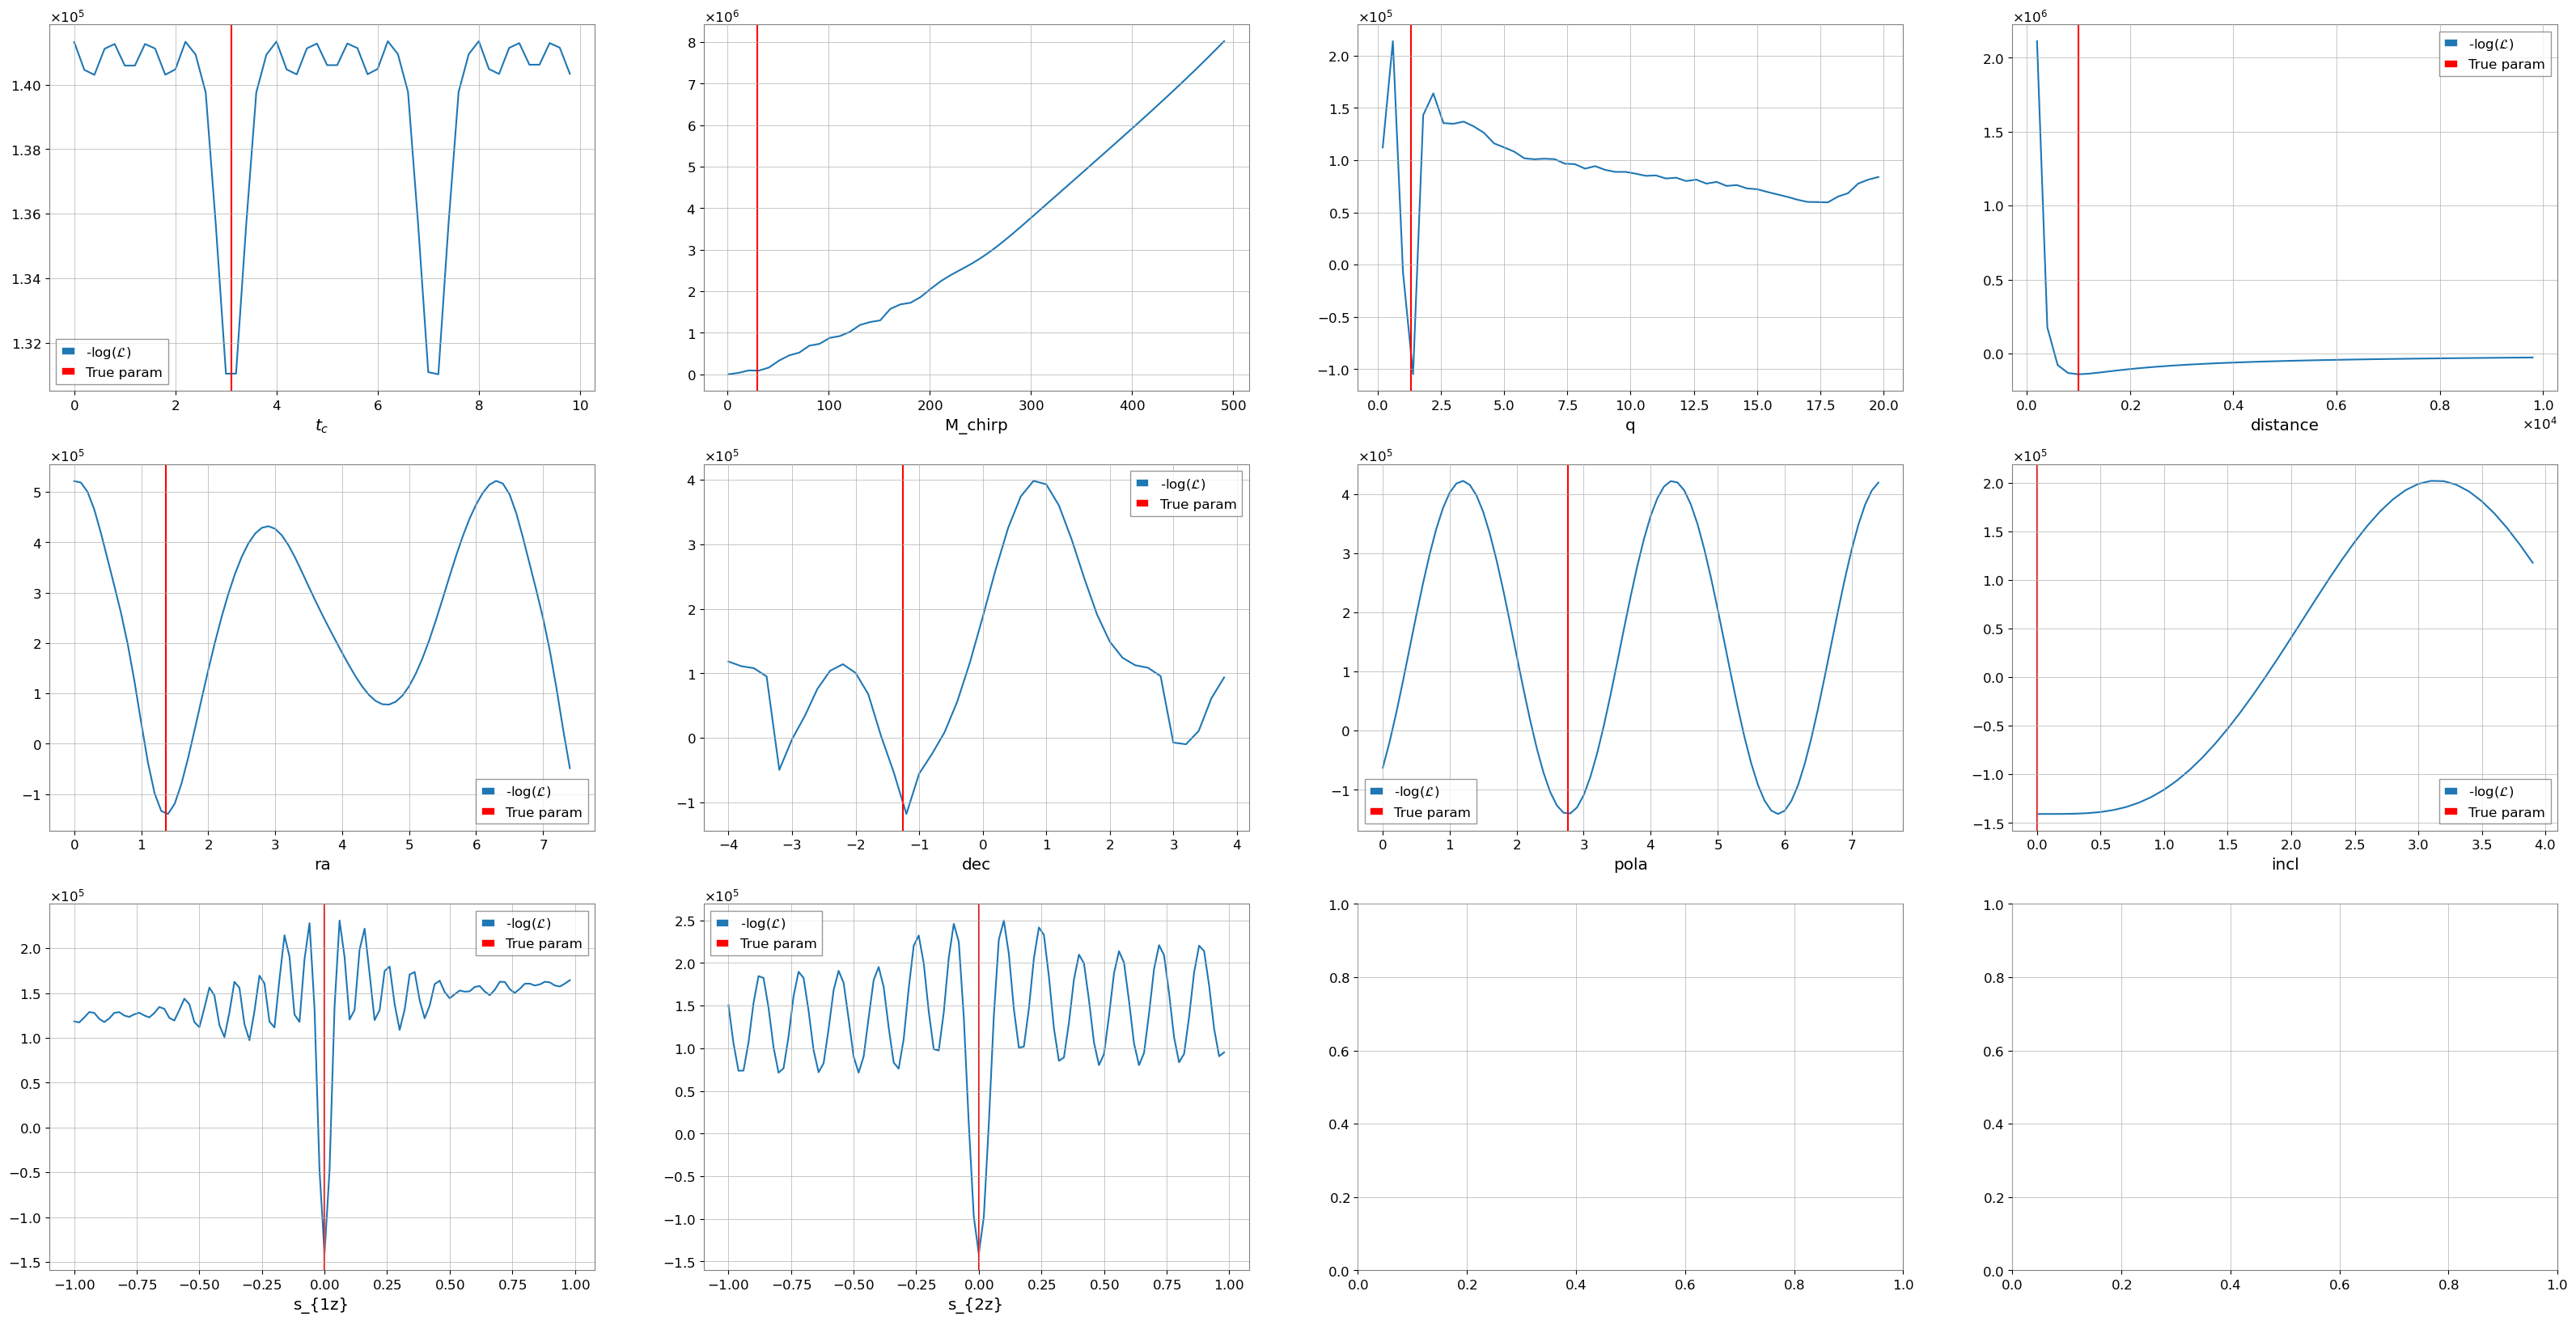

In [66]:
fig_lik, axs = plt.subplots(nrows=3, ncols=4, figsize = (40,20))

true_param = para_reels


def plot_lik(ax,data_x,label_x,true_param,param_min,param_max,echantill,params_dataFrame):

    model.update(tc=true_param[0], mass1 = true_param[1], mass2 = true_param[2], distance = true_param[3],
                 ra = true_param[4], dec = true_param[5], polarization = true_param[6], declination = true_param[7],
                 spin1z = true_param[8], spin2z = true_param[9])

    mchirp_true = mchirp_from_mass1_mass2(true_param[1],true_param[2])
    q_true = q_from_mass1_mass2(true_param[1],true_param[2])

    index_x = params_dataFrame.columns.get_loc(data_x) - 1
    x_grid = np.arange(param_min[index_x],param_max[index_x],echantill[index_x])
    y_grid = np.zeros(len(x_grid))
    for i, x_ in enumerate(x_grid):
        if data_x == 'mass1' :
            mass1 = mass1_from_mchirp_q(mchirp=x_,q=q_true)
            mass2 = mass2_from_mchirp_q(mchirp=x_,q=q_true)
            params = {'mass1' : mass1, 'mass2' : mass2}
            model.update(**params)
            y_grid[i]=-model.loglr
        elif data_x == 'mass2' :
            mass1 = mass1_from_mchirp_q(mchirp=mchirp_true,q=x_)
            mass2 = mass2_from_mchirp_q(mchirp=mchirp_true,q=x_)
            params = {'mass1' : mass1, 'mass2' : mass2}
            model.update(**params)
            y_grid[i]=-model.loglr
        else :
            params = {data_x : x_} #Les paramètres que l'on souhaite modifier sur le modèle de notre GW
            model.update(**params) #Modification du modèle 
            y_grid[i]=-model.loglr
    ax.plot(x_grid,y_grid,label = r"-log($\mathcal{L}$)")
    if data_x == 'mass1' :
        ax.set_xlabel('M_chirp')
        ax.axvline(mchirp_true,color = 'red',label = 'True param')
    elif data_x == 'mass2' :
        ax.set_xlabel('q')
        ax.axvline(q_true,color = 'red',label = 'True param')
    else :
        ax.set_xlabel(label_x)
        ax.axvline(true_param[index_x],color = 'red',label = 'True param')
        ax.legend()

axs_list = [axs[0,0],axs[0,1],axs[0,2],axs[0,3],axs[1,0],axs[1,1],axs[1,2],axs[1,3],axs[2,0],axs[2,1]]
label_x = [r'$t_c$', r'$m_1$', r'$m_2$',  r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}']
data_x = ['tc',   'mass1',    'mass2',    'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z']
param_min = [0,     1, 0.2,    200,   0,  -4,   0,   0,   -1,   -1]
param_max = [10,  500,  20, 10000, 7.5,   4, 7.5,   4,    1,    1]
echantill = [0.2,   10, 0.4,    200, 0.1, 0.2, 0.1, 0.1, 0.02, 0.02]

q=0
for i in range(len(label_x)):
    plot_lik(axs_list[i],data_x[i],label_x[i],true_param,param_min,param_max,echantill,params_dataFrame_glob)
    q += 1
    print('graph {} fini'.format(q),end='\r')

plt.savefig("variation_params_minimisation")

Visualisation des paramètres après optimisation.

In [38]:
para_opti = result_glob.x
#para_opti = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]
mass1_opti = round(mass1_from_mchirp_q(mchirp=para_opti[1],q=para_opti[2]),2)
mass2_opti = round(mass2_from_mchirp_q(mchirp=para_opti[1],q=para_opti[2]),2)
para_opti_rd = [round(i,2) for i in para_opti]
print('Paramètres initiaux :')
print(r'$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(initial_params[0],
     mass1_init, mass2_init, initial_params[3], initial_params[4], initial_params[5],initial_params[6],initial_params[7],initial_params[8],initial_params[9]))
print('\nParamètres d\'optimisation trouvés (local) :')
print(r'$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(para_opti_rd[0],
     mass1_opti, mass2_opti, para_opti_rd[3], para_opti_rd[4], para_opti_rd[5],para_opti_rd[6],para_opti_rd[7],para_opti_rd[8],para_opti_rd[9]))
print('\nParamètres réels :')
print(r'$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5],para_reels[6],para_reels[7],para_reels[8],para_reels[9]))

Paramètres initiaux :
$t_c$ : 2, $m_1$ : 30, $m_2$ : 30, $d_L$ : 5000, ra : 4, dec : 0, pola : 4, incl : 2, s1z : 0, s2z : 0.

Paramètres d'optimisation trouvés (local) :
$t_c$ : 1.82, $m_1$ : 33.97, $m_2$ : 28.07, $d_L$ : 6559.63, ra : 2.85, dec : -0.0, pola : 3.48, incl : 2.02, s1z : 0.0, s2z : 0.0.

Paramètres réels :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0.0, s1z : 0.0, s2z : 0.0.


Evolution de la minimisation.

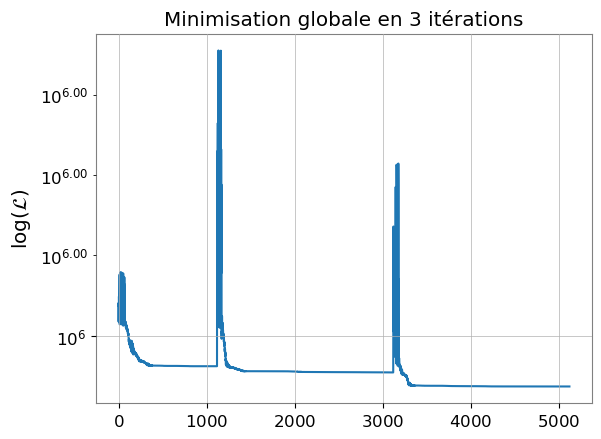

In [41]:
ll_ratio_test=params_dataFrame_glob['mloglik'] + 1000000
x_ = np.arange(len(ll_ratio_test))
plt.plot(x_,ll_ratio_test)
plt.yscale('log')
plt.ylabel(r'log($\mathcal{L}$)')
plt.title('Minimisation globale en 3 itérations')
plt.savefig('minimisation/plot_A')

(OPTION) Récupérer des données issues d'un fichier data.

In [ ]:
nom_fichier = 'params_glob_dataFrame_file_chirp.txt'

params_dataFrame_glob = pd.read_csv("data_files/" + nom_fichier)
para_opti = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]

Plot des graphs d'évolution de la minimisation pour toutes les combinaisons de paramètres associées à notre minimisation : minimums LOCAUX + sauvegarde de la figure dans le dossier partagé Github.

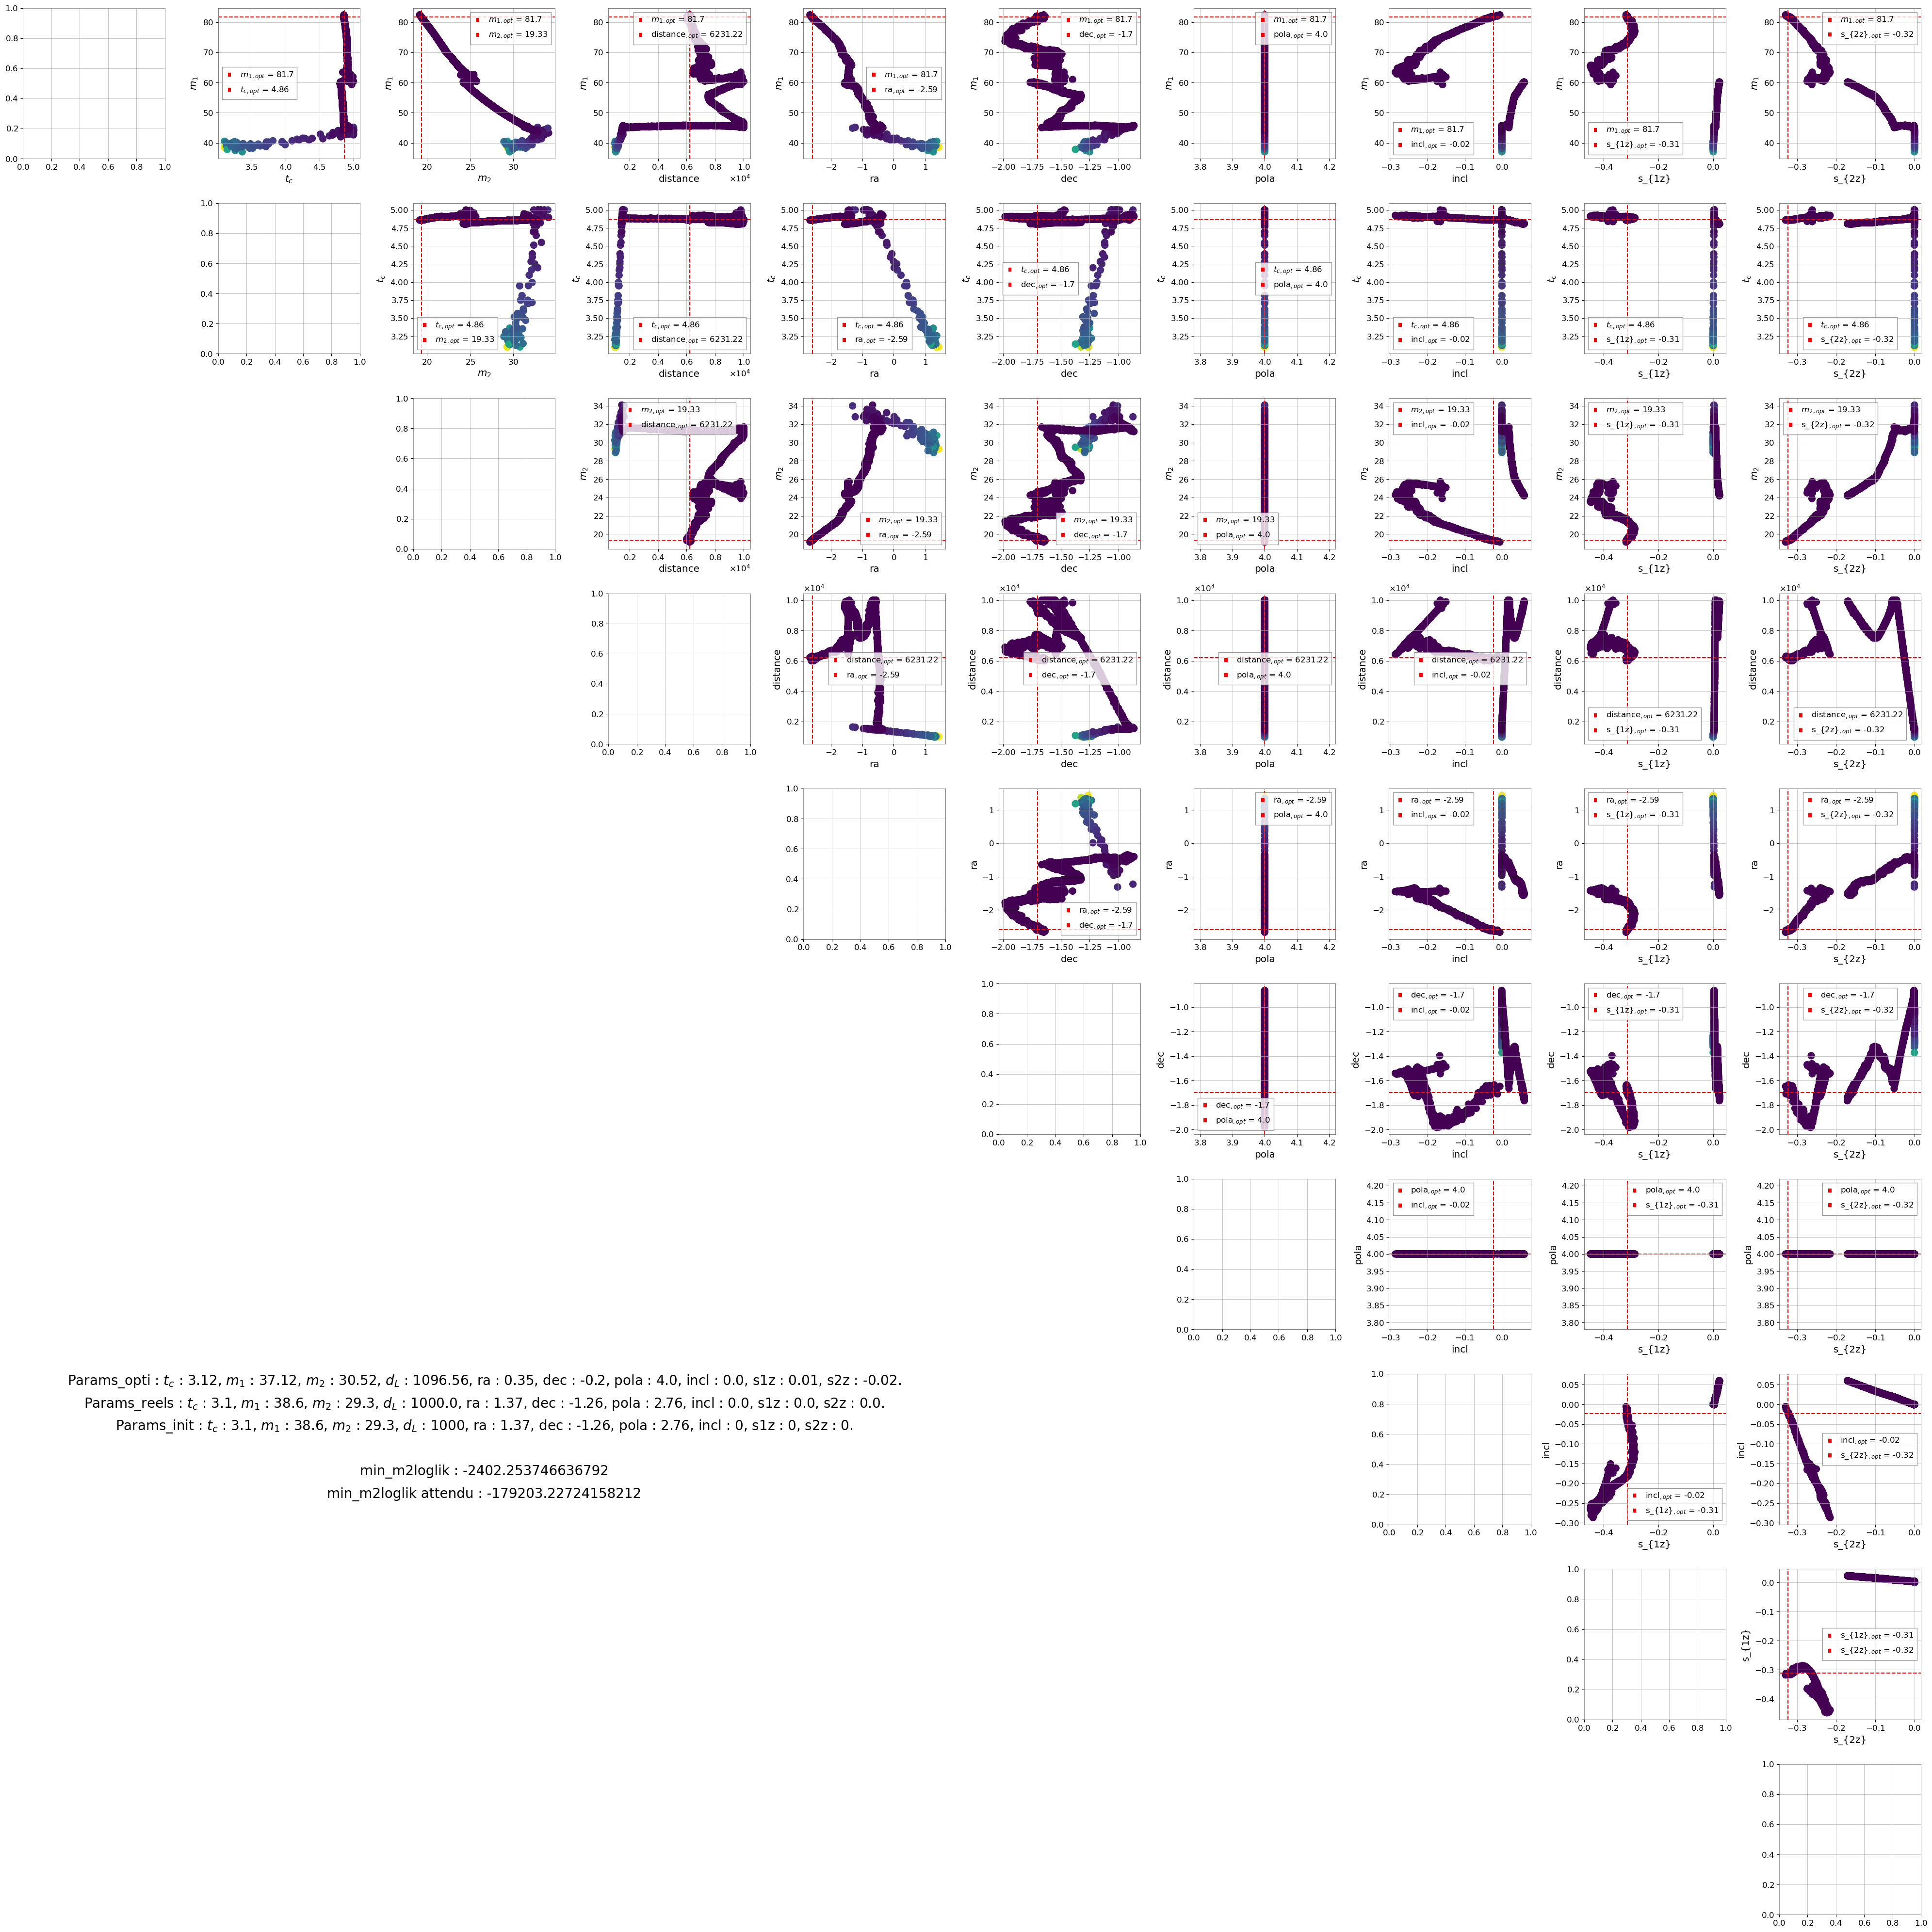

In [ ]:
tc_list=params_dataFrame_glob['tc']
mass1_list=params_dataFrame_glob['mass1']
mass2_list=params_dataFrame_glob['mass2']
distance_list=params_dataFrame_glob['distance']
ra_list=params_dataFrame_glob['ra']
dec_list=params_dataFrame_glob['dec']
pola_list=params_dataFrame_glob['polarization']
incl_list=params_dataFrame_glob['inclination']
s1z_list=params_dataFrame_glob['spin1z']
s2z_list=params_dataFrame_glob['spin2z']
ll_ratio_test=params_dataFrame_glob['mloglik']

nb_params = len(para_reels)
data_tail_glob = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]

fig_2, axs = plt.subplots(nrows=nb_params,ncols=nb_params,figsize=(40,40))

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],   axs[0,6],       axs[0,7],      axs[0,8],   axs[0,9],   axs[1,2],    axs[1,3],     axs[1,4], axs[1,5], axs[1,6],        axs[1,7],      axs[1,8],  axs[1,9],  axs[2,3],      axs[2,4],   axs[2,5],   axs[2,6],       axs[2,7],      axs[2,8],   axs[2,9],   axs[3,4],      axs[3,5],      axs[3,6],       axs[3,7],      axs[3,8],      axs[3,9],      axs[4,5], axs[4,6],       axs[4,7],      axs[4,8],  axs[4,9],  axs[5,6],       axs[5,7],      axs[5,8],  axs[5,9],  axs[6,7],      axs[6,8],       axs[6,9],       axs[7,8],      axs[7,9],      axs[8,9]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   pola_list,      incl_list,     s1z_list,   s2z_list,   mass2_list, distance_list, ra_list,  dec_list,  pola_list,      incl_list,     s1z_list,  s2z_list,  distance_list, ra_list,    dec_list,   pola_list,      incl_list,     s1z_list,   s2z_list,   ra_list,       dec_list,      pola_list,      incl_list,     s1z_list,      s2z_list,      dec_list, pola_list,      incl_list,     s1z_list,  s2z_list,  pola_list,      incl_list,     s1z_list,  s2z_list,  incl_list,     s1z_list,       s2z_list,       s1z_list,      s2z_list,      s2z_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, mass1_list,     mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,   tc_list,        tc_list,       tc_list,   tc_list,   mass2_list,    mass2_list, mass2_list, mass2_list,     mass2_list,    mass2_list, mass2_list, distance_list, distance_list, distance_list,  distance_list, distance_list, distance_list, ra_list,  ra_list,        ra_list,       ra_list,   ra_list,   dec_list,       dec_list,      dec_list,  dec_list,  pola_list,     pola_list,      pola_list,      incl_list,     incl_list,     s1z_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}',  r'$m_2$',   r'distance',   r'ra',    r'dec',    r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}',  r'ra',         r'dec',        r'pola',        r'incl',       r's_{1z}',     r's_{2z}',     r'dec',   r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'incl',       r's_{1z}',      r's_{2z}',      r's_{1z}',     r's_{2z}',     r's_{2z}']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$m_1$',       r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$',  r'$t_c$',       r'$t_c$',      r'$t_c$',  r'$t_c$',  r'$m_2$',      r'$m_2$',   r'$m_2$',   r'$m_2$',       r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'distance',    r'distance',   r'distance',   r'distance',   r'ra',    r'ra',          r'ra',         r'ra',     r'ra',     r'dec',         r'dec',        r'dec',    r'dec',    r'pola',       r'pola',        r'pola',        r'incl',       r'incl',       r's_{1z}']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z',   'mass2',    'distance',    'ra',     'dec',     'polarization', 'inclination', 'spin1z',  'spin2z',  'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z',   'ra',          'dec',         'polarization', 'inclination', 'spin1z',      'spin2z',      'dec',    'polarization', 'inclination', 'spin1z',  'spin2z',  'polarization', 'inclination', 'spin1z',  'spin2z', 'inclination',  'spin1z',       'spin2z',       'spin1z',      'spin2z',      'spin2z']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'mass1',        'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',      'tc',           'tc',          'tc',      'tc',      'mass2',       'mass2',    'mass2',    'mass2',        'mass2',       'mass2',    'mass2',    'distance',    'distance',    'distance',     'distance',    'distance',    'distance',    'ra',     'ra',           'ra',          'ra',      'ra',      'dec',          'dec',         'dec',     'dec',    'polarization', 'polarization', 'polarization', 'inclination', 'inclination', 'spin1z']

for i in range(len(axs_list)):
    plot_corr(x_list[i],y_list[i],label_x[i],label_y[i],data_x[i],data_y[i],axs_list[i],data_tail_glob)

fig_2.tight_layout()

axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[6,0],axs[7,0],axs[8,0],axs[9,0],
           axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4],
           axs[6,1],axs[6,2], axs[6,3], axs[6,4],axs[6,5],
           axs[7,1],axs[7,2], axs[7,3], axs[7,4],axs[7,5],axs[7,6],
           axs[8,1],axs[8,2], axs[8,3], axs[8,4],axs[8,5],axs[8,6],axs[8,7],
           axs[9,1],axs[9,2], axs[9,3], axs[9,4],axs[9,5],axs[9,6],axs[9,7],axs[9,8]]
for i in axs_off:
    i.axis('off')

ax=axs[7,2]
ax.text(0.5, 0.95, r'Params_opti : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(round(para_opti[0],2),
     mass1_opti, mass2_opti, round(para_opti[3],2), round(para_opti[4],2), round(para_opti[5],2),round(para_opti[6],2),round(para_opti[7],2),round(para_opti[8],2),
     round(para_opti[9],2)), horizontalalignment='center',verticalalignment='center',fontsize=20)
ax.text(0.5, 0.80, r'Params_reels : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5],para_reels[6],para_reels[7],para_reels[8],para_reels[9]), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
ax.text(0.5, 0.65, r'Params_init : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(initial_params[0],
     mass1_init, mass2_init, initial_params[3], initial_params[4], initial_params[5],initial_params[6],initial_params[7],initial_params[8],
     initial_params[9]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=20)
ax.text(0.5, 0.35, r'min_m2loglik : {}'.format(result_glob.fun), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
ax.text(0.5, 0.20, r'min_m2loglik attendu : {}'.format(log_noise_likelihood_from_SNR), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)

#plt.savefig("minimisation/Full_2it_Minimisation_globaux_signal")

Plot des corrélations des différents paramètres de notre GW. Nous faisons une gille 2D pour chaque combinaison de 2 paramètres (laissés libres) et nous fixons tous les autres à leur valeur réelle.

Plots total : 45, plot : 1
Iterations totales :  900
(30, 30)
Maximum log-likelihood ratio at:5583.701859894543
inclination = 0.9
mass1 = 38.52


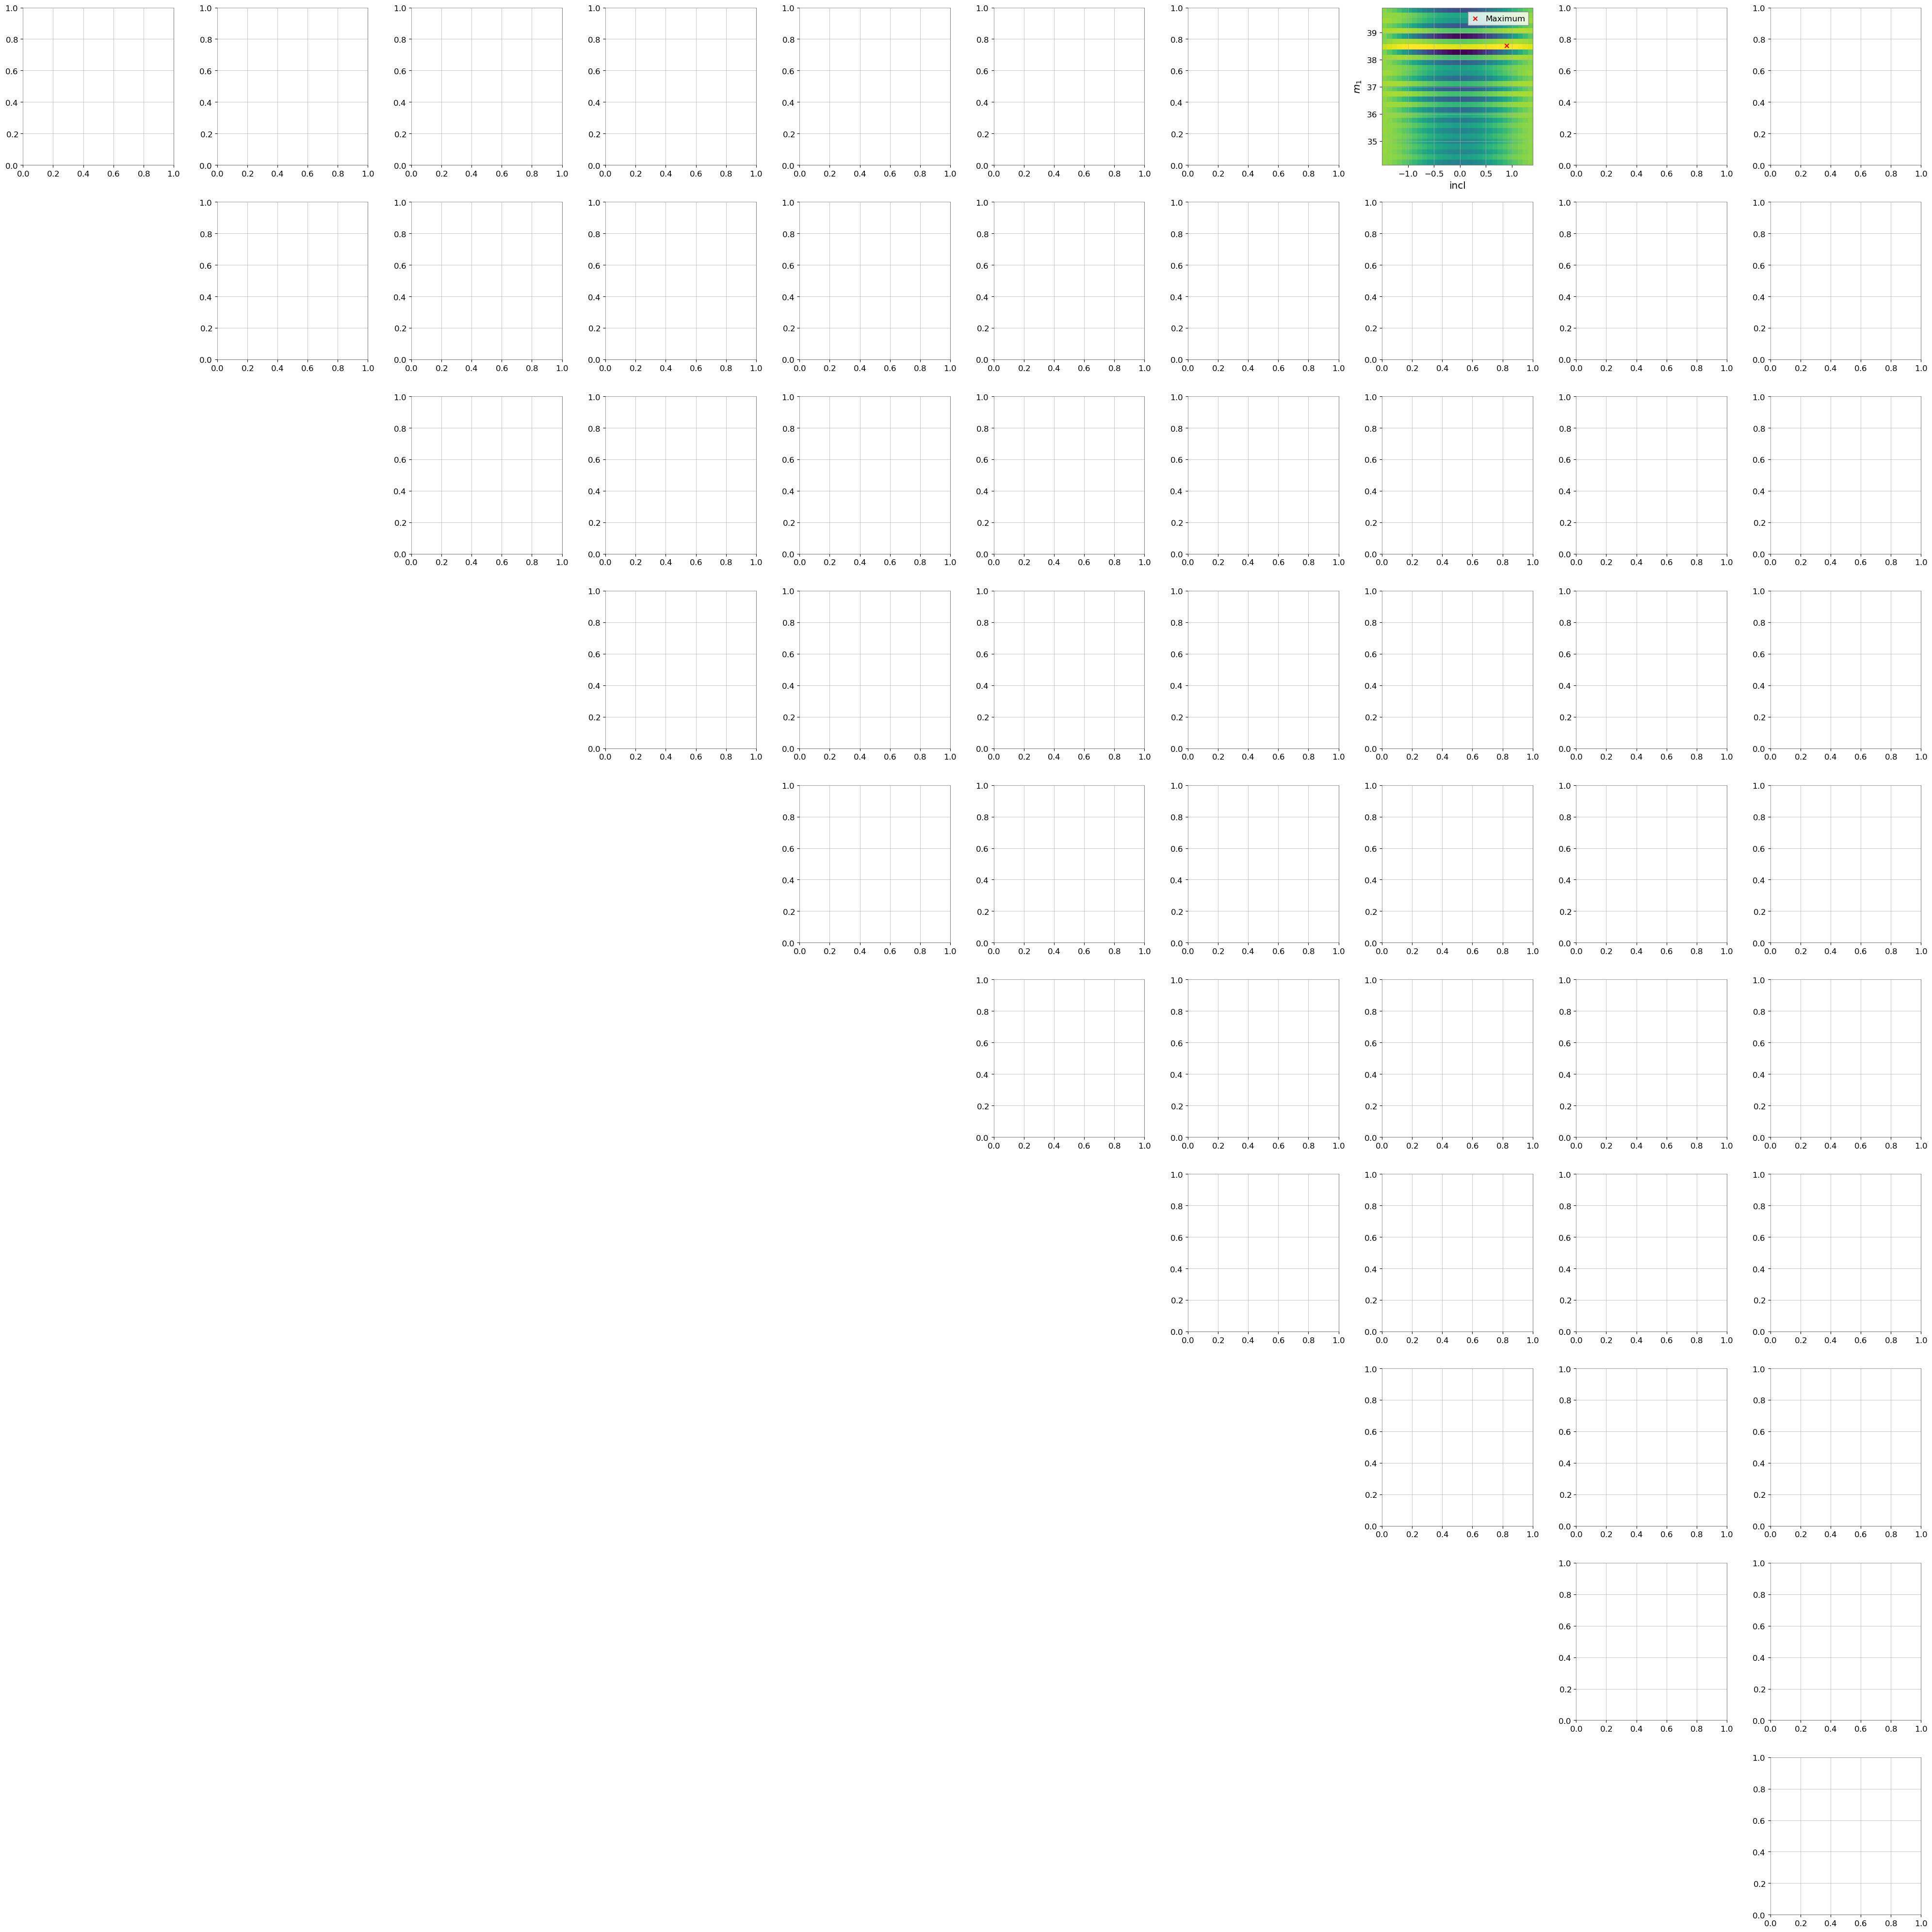

In [85]:
nb_params = len(para_reels)
fig_3, axs = plt.subplots(nrows=nb_params,ncols=nb_params,figsize=(40,40))


def plot_grid_correlation(id,data_x,data_y,axs_list,label_x,label_y,param_min,param_max,params_dataFrame):

    model.update(tc=cbc_params['tc'], mass1 = cbc_params['mass1'], mass2 = cbc_params['mass2'],
                distance = cbc_params['distance'], ra = cbc_params['ra'], dec = cbc_params['dec'])


    index_x = params_dataFrame.columns.get_loc(data_x) - 1
    index_y = params_dataFrame.columns.get_loc(data_y) - 1


    x_grid = np.arange(param_min[index_x],param_max[index_x],echantill[index_x])
    y_grid = np.arange(param_min[index_y],param_max[index_y],echantill[index_y])


    print("Iterations totales : ",len(x_grid)*len(y_grid))
    k=0

    ll_ratio_grid = np.zeros((len(x_grid), len(y_grid)))
    print(ll_ratio_grid.shape)

    for i, x_ in enumerate(x_grid):
        for j, y_ in enumerate(y_grid):
            params = {data_x : x_ ,  data_y : y_} #Les paramètres que l'on souhaite modifier sur le modèle de notre GW
            model.update(**params) #Modification du modèle 
            ll_ratio_grid[i,j] = model.loglr #calcul du likelihood ratio
            k +=1 #Compteur du nombre d'itérations
            print ("Iteration : {}, likelihood : {}".format(k,ll_ratio_grid[i,j]), end="\r")
            #time.sleep(0.1)
    max_index = np.unravel_index(np.argmax(ll_ratio_grid), ll_ratio_grid.shape)

    # Extract corresponding m1 and m2 values
    x_max = x_grid[max_index[0]]
    y_max = y_grid[max_index[1]]

    print("Maximum log-likelihood ratio at:")
    print(data_x + ' = ' + str(round(x_max,2)))
    print(data_y + " = " + str(round(y_max,2)))

    axs_list.imshow(ll_ratio_grid.T,  # Transpose to align axes correctly
            origin='lower',   # Make sure lower m1/m2 is at bottom-left
            extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            aspect='auto',    # Or use 'equal' if square pixels are desired
            cmap='viridis')   # You can change colormap as desired
    axs_list.scatter(x_max, y_max, marker='x', color='red', label='Maximum')
    axs_list.legend()
    axs_list.set_xlabel(label_x)
    axs_list.set_ylabel(label_y)
    #axs_list.axhline(x_max,y_grid[0],y_grid[-1],linestyle = 'dashed',color='r') #, label=label_y + r'$_{,opt}$ = ' + str(round(float(data_tail[data_y]),2)))
    #axs_list.axvline(y_max,x_grid[0],x_grid[-1],linestyle = 'dashed',color='r') #, label=label_x + r'$_{,opt}$ = ' + str(round(float(data_tail[data_x]),2)))

    #axs_list.title('Log-Likelihood Ratio as a Function of Mass 1 and Mass 2')

#indexes_params = pd.DataFrame(data={'tc': [0], 'mass1': [1],
#                                     'mass2': [2], 'distance': [3], 'ra' : [4], 'dec' : [5]})

#ind_fig = 1          2           3              4           5           6               7              8           9           10           11            12        13        14               15             16         17         18             19          20          21              22             23          24          25             26             27              28             29             30             31        32              33             34         35         36              37             38         39         40             41              42              43             44             45
axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],   axs[0,6],       axs[0,7],      axs[0,8],   axs[0,9],   axs[1,2],    axs[1,3],     axs[1,4], axs[1,5], axs[1,6],        axs[1,7],      axs[1,8],  axs[1,9],  axs[2,3],      axs[2,4],   axs[2,5],   axs[2,6],       axs[2,7],      axs[2,8],   axs[2,9],   axs[3,4],      axs[3,5],      axs[3,6],       axs[3,7],      axs[3,8],      axs[3,9],      axs[4,5], axs[4,6],       axs[4,7],      axs[4,8],  axs[4,9],  axs[5,6],       axs[5,7],      axs[5,8],  axs[5,9],  axs[6,7],      axs[6,8],       axs[6,9],       axs[7,8],      axs[7,9],      axs[8,9]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   pola_list,      incl_list,     s1z_list,   s2z_list,   mass2_list, distance_list, ra_list,  dec_list,  pola_list,      incl_list,     s1z_list,  s2z_list,  distance_list, ra_list,    dec_list,   pola_list,      incl_list,     s1z_list,   s2z_list,   ra_list,       dec_list,      pola_list,      incl_list,     s1z_list,      s2z_list,      dec_list, pola_list,      incl_list,     s1z_list,  s2z_list,  pola_list,      incl_list,     s1z_list,  s2z_list,  incl_list,     s1z_list,       s2z_list,       s1z_list,      s2z_list,      s2z_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, mass1_list,     mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,   tc_list,        tc_list,       tc_list,   tc_list,   mass2_list,    mass2_list, mass2_list, mass2_list,     mass2_list,    mass2_list, mass2_list, distance_list, distance_list, distance_list,  distance_list, distance_list, distance_list, ra_list,  ra_list,        ra_list,       ra_list,   ra_list,   dec_list,       dec_list,      dec_list,  dec_list,  pola_list,     pola_list,      pola_list,      incl_list,     incl_list,     s1z_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}',  r'$m_2$',   r'distance',   r'ra',    r'dec',    r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}',  r'ra',         r'dec',        r'pola',        r'incl',       r's_{1z}',     r's_{2z}',     r'dec',   r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'pola',        r'incl',       r's_{1z}', r's_{2z}', r'incl',       r's_{1z}',      r's_{2z}',      r's_{1z}',     r's_{2z}',     r's_{2z}']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$m_1$',       r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$',  r'$t_c$',       r'$t_c$',      r'$t_c$',  r'$t_c$',  r'$m_2$',      r'$m_2$',   r'$m_2$',   r'$m_2$',       r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'distance',    r'distance',   r'distance',   r'distance',   r'ra',    r'ra',          r'ra',         r'ra',     r'ra',     r'dec',         r'dec',        r'dec',    r'dec',    r'pola',       r'pola',        r'pola',        r'incl',       r'incl',       r's_{1z}']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z',   'mass2',    'distance',    'ra',     'dec',     'polarization', 'inclination', 'spin1z',  'spin2z',  'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z',   'ra',          'dec',         'polarization', 'inclination', 'spin1z',      'spin2z',      'dec',    'polarization', 'inclination', 'spin1z',  'spin2z',  'polarization', 'inclination', 'spin1z',  'spin2z', 'inclination',  'spin1z',       'spin2z',       'spin1z',      'spin2z',      'spin2z']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'mass1',        'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',      'tc',           'tc',          'tc',      'tc',      'mass2',       'mass2',    'mass2',    'mass2',        'mass2',       'mass2',    'mass2',    'distance',    'distance',    'distance',     'distance',    'distance',    'distance',    'ra',     'ra',           'ra',          'ra',      'ra',      'dec',          'dec',         'dec',     'dec',    'polarization', 'polarization', 'polarization', 'inclination', 'inclination', 'spin1z']
param_min = [cbc_params['tc']-1.5,cbc_params['mass1']-3,cbc_params['mass2']-3,cbc_params['distance']-3,cbc_params['ra']-1.5,cbc_params['dec']-1.5,cbc_params['polarization']-1.5,cbc_params['inclination']-1.5,cbc_params['spin1z']-1.5,cbc_params['spin2z']-1.5]
param_max = [cbc_params['tc']+1.5,cbc_params['mass1']+3,cbc_params['mass2']+3,cbc_params['distance']+3,cbc_params['ra']+1.5,cbc_params['dec']+1.5,cbc_params['polarization']+1.5,cbc_params['inclination']+1.5,cbc_params['spin1z']+1.5,cbc_params['spin2z']+1.5]
echantill = [0.1               ,0.2                   ,0.2                   ,0.2                     ,0.1                 ,0.1                  ,0.1                           ,0.1                          ,0.1                     ,0.1                     ]

indices_interet = [6]
#,7,8,9,14,15,16,17,21,22,23,24,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45]
p=0
#for i in range(len(axs_list)):
for i in indices_interet:
    p +=1
    print ("Plots total : {}, plot : {}".format(len(axs_list),p))
    plot_grid_correlation(i,data_x[i],data_y[i],axs_list[i],label_x[i],label_y[i],param_min,param_max,params_dataFrame_glob)

axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[6,0],axs[7,0],axs[8,0],axs[9,0],
           axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4],
           axs[6,1],axs[6,2], axs[6,3], axs[6,4],axs[6,5],
           axs[7,1],axs[7,2], axs[7,3], axs[7,4],axs[7,5],axs[7,6],
           axs[8,1],axs[8,2], axs[8,3], axs[8,4],axs[8,5],axs[8,6],axs[8,7],
           axs[9,1],axs[9,2], axs[9,3], axs[9,4],axs[9,5],axs[9,6],axs[9,7],axs[9,8]]

for i in axs_off:
    i.axis('off')
fig_3.tight_layout()
#fig_3.colorbar(label='Log-Likelihood Ratio')

plt.savefig('Others_params_correlation')

Plot pour graph de corrélation avec seulement 2 paramètres.

Iterations totales :  5400
(180, 30)
Maximum log-likelihood ratio at:193501.50059718842
distance = 1000
inclination = 0.0


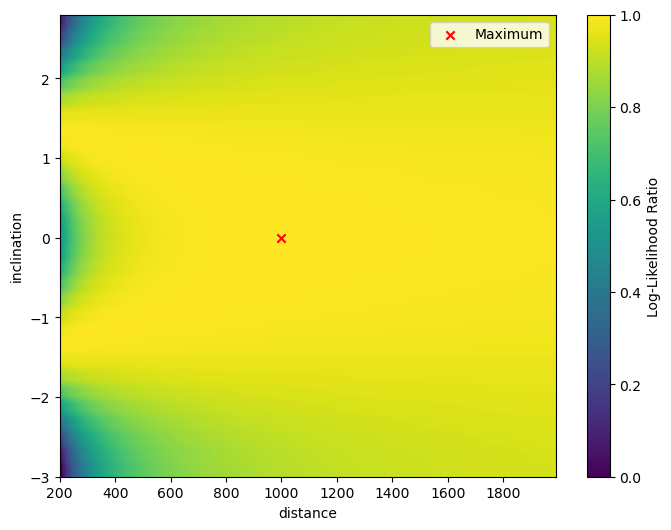

In [ ]:
model.update(tc=cbc_params['tc'], mass1 = cbc_params['mass1'], mass2 = cbc_params['mass2'], inclination = 0,
                distance = cbc_params['distance'], ra = cbc_params['ra'], dec = cbc_params['dec'],
                polarization = cbc_params['polarization'],declination = cbc_params['declination'],
                spin1z = cbc_params['spin1z'],spin2z = cbc_params['spin2z'])

#Params =============================
Nom = 'V4'
param_x_name = 'distance'
param_y_name = 'inclination'
borne_x = 500
ech_x = 10
borne_y = 3
ech_y = 0.2
#====================================

x_grid = np.arange(cbc_params[param_x_name] - borne_x, cbc_params[param_x_name] + borne_x, ech_x)
y_grid = np.arange(cbc_params[param_y_name] - borne_y, cbc_params[param_y_name] + borne_y, ech_y)

print("Iterations totales : ",len(x_grid)*len(y_grid))
k=0

ll_ratio_grid_unit = np.zeros((len(x_grid), len(y_grid)))
print(ll_ratio_grid_unit.shape)

for i, x_ in enumerate(x_grid):
    for j, y_ in enumerate(y_grid):
        params = {param_x_name : x_ ,  param_y_name : y_} #Les paramètres que l'on souhaite modifier sur le modèle de notre GW
        model.update(**params) #Modification du modèle 
        ll_ratio_grid_unit[i,j] = model.loglr #calcul du likelihood ratio
        k +=1 #Compteur du nombre d'itérations
        print ("Iteration : {}, likelihood : {}".format(k,ll_ratio_grid_unit[i,j]), end="\r")
        #time.sleep(0.1)

max_index = np.unravel_index(np.argmax(ll_ratio_grid_unit), ll_ratio_grid_unit.shape)

# Extract corresponding m1 and m2 values
x_max = x_grid[max_index[0]]
y_max = y_grid[max_index[1]]

print("Maximum log-likelihood ratio at:")
print(param_x_name + ' = ' + str(round(x_max,2)))
print(param_y_name + " = " + str(round(y_max,2)))

plt.figure(figsize=(8, 6))
plt.imshow(ll_ratio_grid_unit.T,  # Transpose to align axes correctly
        origin='lower',   # Make sure lower m1/m2 is at bottom-left
        extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
        aspect='auto',    # Or use 'equal' if square pixels are desired
        cmap='viridis')   # You can change colormap as desired
plt.scatter(x_max, y_max, marker='x', color='red', label='Maximum')
plt.legend()
plt.colorbar(label='Log-Likelihood Ratio')
plt.xlabel(r'distance')
plt.ylabel(r'inclination')

plt.savefig(Nom + "_" + param_x_name + "_" + param_x_name)

Plot pour graph de corrélation entre la mass ratio et la chrip mass : on constate donc que ces deux paramètres dont décorrélés et il est donc préférable de les utiliser dans la minimisation plutôt que $m_1$ et $m_2$.

In [ ]:
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
mchirp_true = mchirp_from_mass1_mass2(cbc_params["mass1"], cbc_params["mass2"])
q_true = q_from_mass1_mass2(cbc_params["mass1"], cbc_params["mass2"])
print("Chirp mass of the system: " + str(mchirp_true))
print("Mass ratio of the system: " + str(q_true))

37.11580750625587
37.11580750625587
30.52473415640889
30.52473415640889
Chirp mass of the system: 29.274202120237604
Mass ratio of the system: 1.2159256593709968


In [88]:
model.update(tc=cbc_params['tc'], mass1=cbc_params['mass1'], mass2=cbc_params['mass2'])

mchirp_grid = np.arange(20,40, 0.2)
q_grid = np.arange(1,2,0.2)

ll_ratio_grid_mchirp = np.zeros((len(mchirp_grid), len(q_grid)))
print("Iterations totales : ",len(mchirp_grid)*len(q_grid))
k=0
for i, m in enumerate(mchirp_grid):
    for j, qq in enumerate(q_grid):
        m1 = mass1_from_mchirp_q(m, qq)
        m2 = mass2_from_mchirp_q(m, qq)
        model.update(mass1=m1, mass2=m2)
        ll_ratio_grid_mchirp[i,j] = model.loglr
        k +=1 #Compteur du nombre d'itérations
        print ("Iteration : {}, likelihood : {}".format(k,ll_ratio_grid_mchirp[i,j]), end="\r")

Iterations totales :  500


KeyboardInterrupt: 

Maximum log-likelihood ratio at:
Chirp mass = 29.20000000000013
Mass ratio = 1.4000000000000004


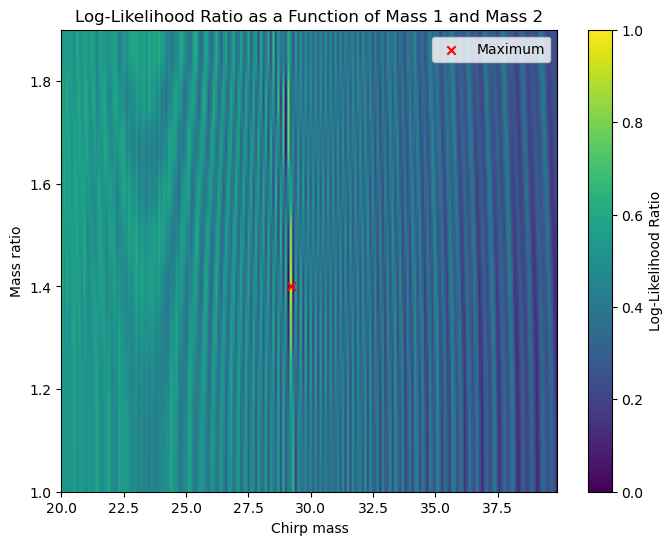

In [ ]:
ll_ratio_grid_mchirp = ll_ratio_grid
max_index = np.unravel_index(np.argmax(ll_ratio_grid_mchirp), ll_ratio_grid_mchirp.shape)

# Extract corresponding m1 and m2 values
m_max = mchirp_grid[max_index[0]]
q_max = q_grid[max_index[1]]

print("Maximum log-likelihood ratio at:")
print("Chirp mass = " + str(m_max))
print("Mass ratio = " + str(q_max))

plt.figure(figsize=(8, 6))
plt.imshow(ll_ratio_grid_mchirp.T,  # Transpose to align axes correctly
           origin='lower',   # Make sure lower m1/m2 is at bottom-left
           extent=[mchirp_grid[0], mchirp_grid[-1], q_grid[0], q_grid[-1]],
           aspect='auto',    # Or use 'equal' if square pixels are desired
           cmap='viridis')   # You can change colormap as desired
plt.scatter(m_max, q_max, marker='x', color='red', label='Maximum')
plt.legend()
plt.colorbar(label='Log-Likelihood Ratio')
plt.xlabel('Chirp mass')
plt.ylabel('Mass ratio')
plt.title('Log-Likelihood Ratio as a Function of Mass 1 and Mass 2')

#plt.savefig('Chirp_mass_Mass_ratio')

Comparaison des signaux.

In [148]:
signal_reel = signal

seglen = 4
sample_rate = 2048

N = int(seglen * sample_rate / 2 + 1) # Number of samples in the frequency series

fmin = 5.

# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
              # Paramètres intrinsèques à la source
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
              'eccentricity': 0,
              # Paramètres extrinsèques
              'ra': 1.37, 'dec': -1.26, 'distance': 1000,
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0}

para_reels = np.array([3.1, 38.6, 29.3, 1000, 1.37, -1.26,2.76,0,0,0])

cbc_params['approximant'] = 'IMRPhenomD'
#IMRPhenomXAS (modèle plus simple)
cbc_params['f_lower'] =  fmin

generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1', 'L1'],
    delta_f=1./seglen, **cbc_params)

signal_reel = generator.generate()

psd = EinsteinTelescopeP1600143(N, 1./seglen, fmin)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}

noise = frequency_noise_from_psd(psd)
signal['H1'] = signal['H1'] + noise
signal['L1'] = signal['L1'] + noise

TSL1_reel = signal_reel['L1'].to_timeseries()
TSH1_reel = signal_reel['H1'].to_timeseries()



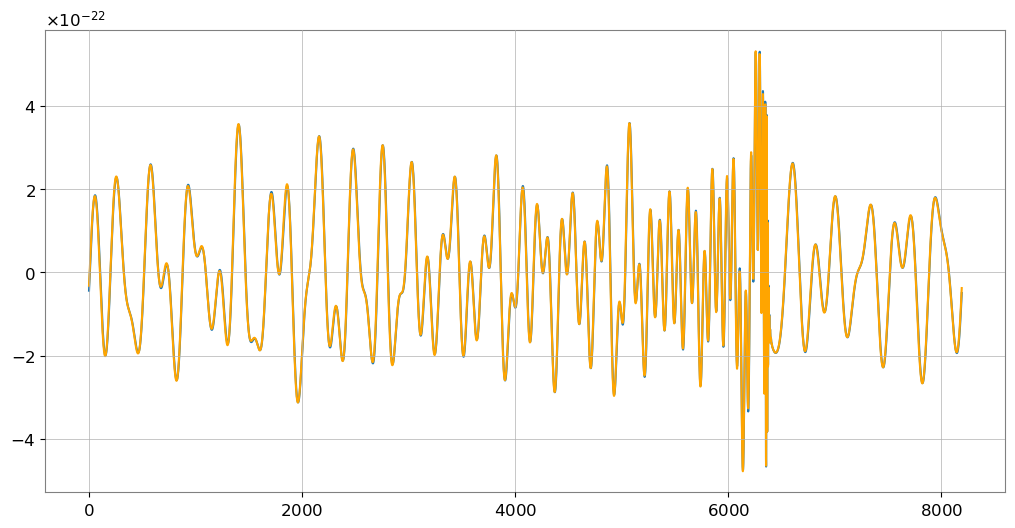

In [149]:
para_opti = result.x
# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
              # Paramètres intrinsèques à la source
              'mass1': mass1_opti,
              'mass2': mass2_opti,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': para_opti[8], 'spin2z': para_opti[9],
              'eccentricity': 0,
              # Paramètres extrinsèques
              'ra': para_opti[4], 'dec': para_opti[5], 'distance': para_opti[3],
              'polarization': para_opti[6], 'inclination': para_opti[7],
              'tc': para_opti[0] , 'coa_phase': 0}

para_reels = np.array([3.1, 38.6, 29.3, 1000, 1.37, -1.26, 2.76, 0, 0, 0])

cbc_params['approximant'] = 'IMRPhenomD'
#IMRPhenomXAS (modèle plus simple)
cbc_params['f_lower'] =  fmin

# Définition du générateur
generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1', 'L1'],
    delta_f=1./seglen, **cbc_params)

# Génération du signal
signal_opti = generator.generate()
TSL1_opti = signal_opti['L1'].to_timeseries()
TSH1_opti = signal_opti['H1'].to_timeseries()
plot = Plot(TSL1_opti, figsize=(12, 6))
ax = plot.gca()
ax.plot(TSL1_reel, label='L1', color='orange')

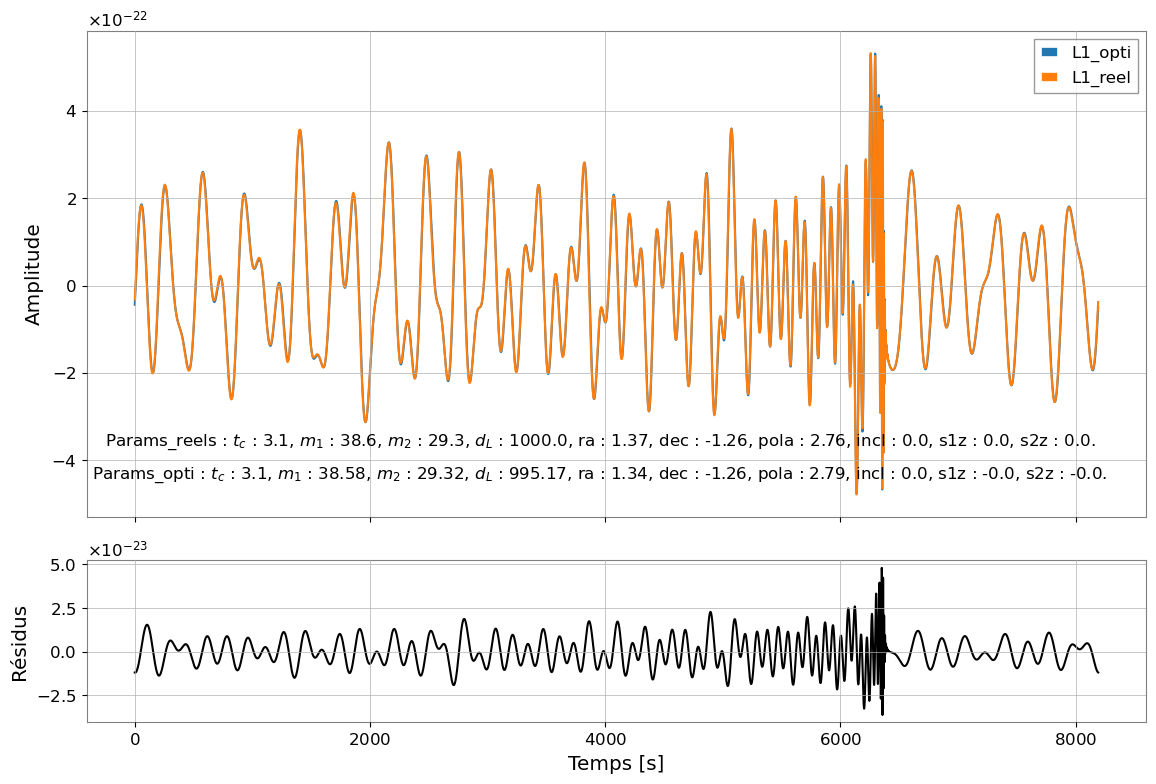

In [151]:
# Calcul de la différence
residual = TSL1_opti - TSL1_reel

# Création des subplots : 2 lignes, 1 colonne, partagent l'axe X
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Tracer les deux signaux dans le premier axe
ax1.plot(TSL1_opti, label='L1_opti')
ax1.plot(TSL1_reel, label='L1_reel')
ax1.set_ylabel('Amplitude')
ax1.text(0.5, 0.5, r'Params_opti : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(round(para_opti[0],2),
     mass1_opti, mass2_opti, round(para_opti[3],2), round(para_opti[4],2),round(para_opti[5],2), round(para_opti[6],2),round(para_opti[7],2),
     round(para_opti[8],2),round(para_opti[9],2)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax1.text(0.5, 0.57, r'Params_reels : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5], para_reels[6], para_reels[7], para_reels[8], para_reels[9]), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax1.legend()

# Tracer la différence dans le second axe
ax2.plot(residual, color='black')
ax2.set_ylabel('Résidus')
ax2.set_xlabel('Temps [s]')

plt.tight_layout()
plt.savefig("Full_loc_minim_L1_Comparaison_signal")

In [ ]:
psd = EinsteinTelescopeP1600143(N, 1./seglen, fmin)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}

model = GaussianNoise(['mass1', 'mass2', 'tc'], signal, low_frequency_cutoff,
                          psds=psds, static_params=cbc_params)